In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker


def plot_users_frequency():
    data = []
    total_access = 0
    for u in users:
        data.append({'user_id': u, 'freq': users[u]})
        total_access += users[u]
    du = pd.DataFrame(data)
    du = du.sort_values(by='freq', ascending=False).reset_index(drop=True).reset_index(drop=False)
    du['prob'] = du['freq']/total_access
    sns.set_style("ticks")
    sns.set_context("paper", font_scale=1)
    sns.set_context(rc = {'patch.linewidth': 1.5, 'patch.color': 'black'})
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(8,4))
    sns.lineplot(x='index', y='prob', data=du, ax=ax)
    sns.despine()
    ax.set_xlabel(f'User rank (truncated at 100, # of users {len(du)})\nbenchmark: {t}', fontsize=14)
    ax.set_ylabel(f'Probablity', fontsize=14)
    ax.set_xscale('log',base =2)
    ax.set_yscale('log',base =2)
    

    return du


trace: zipfusers1.2.512M policy: crr 
# of requests in trace 14301 
# of distinct users 2606 
Total # of object 128329 
Total # of reads 519116 
total # of access 519116 
Maximum object hit ratio 0.7528 
Object hit ratio 0.72905 
Working-set size 13 GB (14449723904 B) 
Cache size 2560 MB 





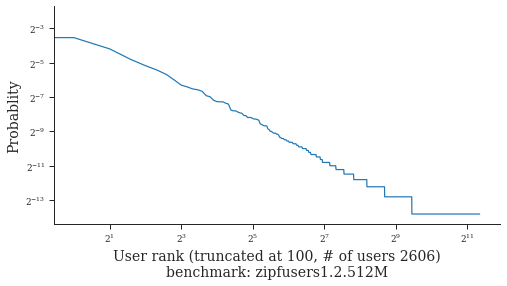

In [135]:
#get users frequency 
import json

tests = ['zipfusers1.2.512M', 'randomusers', 'zipfusers0.7']

for t in tests:
    wdir = f'/home/mania/serverless-social-network-multithreaded/functions/results/{t}/'
    policies = ['crr']#, 'ch']
    if '512M' in t:
        cache_size = 5*512
    else:
        cache_size = 5*128
        
    tpath = os.path.join(wdir, 'trace.json')
    with open(tpath, 'r') as fd:
        users = {}
        data = json.load(fd)
        n_requests = len(data)
        for d in data:
            for op in d:
                user_id = d[op]['user_id']
                if user_id not in users:
                    users[user_id] = 0
                users[user_id] += 1


    for p in policies:
        t_misses = 0
        t_hits = 0
        df_list = []
        obj_size = {}
        for i in range(0, 5):
            path = os.path.join(wdir, f'{p}/localhost_3700{i}.post_media_cache.cache.log')
            di = pd.read_csv(path, 
                             names=['cache', 'action', 'oid', 'access', 'size', 'used', 'capacity'], header=None)
            df_list.append(di)


        df = pd.concat(df_list)
        df.apply(lambda x: get_size(x['oid'], x['size'], obj_size), axis =1, args=(obj_size))
        total_data_accessed = sum(list(obj_size.values()))

        for i in range(0, 5):
            path = os.path.join(wdir, f'{p}/localhost_3700{i}.post_media_cache.cache.log')
            di = pd.read_csv(path, 
                             names=['cache', 'action', 'oid', 'access', 'size', 'used', 'capacity'], header=None)

            hits = len(di[(di['action'] == 'get') & (di['access'] == 'hit')])
            t_hits += hits   
            misses = len(di[(di['action'] == 'get') & (di['access'] == 'miss')])
            t_misses += misses

        print('trace:', t,
              'policy:', p, 
              '\n# of requests in trace', n_requests,
              '\n# of distinct users', len(users),
              '\nTotal # of object', df['oid'].nunique(),
              '\nTotal # of reads', len(df[df['action'] == 'get']),
              '\ntotal # of access', t_misses + t_hits,
              '\nMaximum object hit ratio', round(1 - df['oid'].nunique()/len(df[df['action'] == 'get']) , 4),
              '\nObject hit ratio', round(t_hits/(t_misses+t_hits), 5),
              '\nWorking-set size', f'{total_data_accessed >> 30} GB', f'({total_data_accessed} B)',
              '\nCache size', f'{cache_size} MB', '\n\n\n')
        #break
    du = plot_users_frequency()
    break


    

In [115]:
du

,index,user_id,freq,prob
0,0,23323,24,0.015779
1,1,31441,17,0.011177
2,2,17261,9,0.005917
3,3,14413,6,0.003945
4,4,24345,5,0.003287
...,...,...,...,...
1360,1360,33243,1,0.000657
1361,1361,6675,1,0.000657
1362,1362,3923,1,0.000657
1363,1363,28594,1,0.000657


In [35]:
wdir = '/home/mania/serverless-social-network-multithreaded/functions/results/zipfusers0.7'

t_misses = 0
t_hits = 0

missed_bytes = 0
hit_bytes = 0

random_df_list = []

for i in range(0, 5):
    path = os.path.join(wdir, f'crr/localhost_3700{i}.post_media_cache.cache.log')
    di = pd.read_csv(path, 
                     names=['cache', 'action', 'oid', 'access', 'size', 'used', 'capacity'], header=None)

    hits = len(di[(di['action'] == 'get') & (di['access'] == 'hit')])
    t_hits += hits   
    misses = len(di[(di['action'] == 'get') & (di['access'] == 'miss')])
    t_misses += misses
    
    random_df_list.append(di)
    
    objs = {}
    #di.apply(lambda x: get_size(x['oid'], x['size'], obj_size), axis =1, args=(obj_size))
    print('\t post_media cache worker', 37000 + i ,
          ', hits:', hits, 'misses:', misses, 
          ', hit-ratio', round(hits/(misses+hits), 2))

df = pd.concat(random_df_list)
    

obj_size = {}        
df.apply(lambda x: get_size(x['oid'], x['size'], obj_size), axis =1, args=(obj_size))
total_data_accessed = sum(list(obj_size.values()))

print('hit-ratio', round(t_hits/(t_misses+t_hits), 5) ,
      'misses', t_misses, 'hits', t_hits)

print()

	 post_media cache worker 37000 , hits: 399 misses: 24383 , hit-ratio 0.02
	 post_media cache worker 37001 , hits: 446 misses: 24579 , hit-ratio 0.02
	 post_media cache worker 37002 , hits: 337 misses: 24434 , hit-ratio 0.01
	 post_media cache worker 37003 , hits: 340 misses: 24725 , hit-ratio 0.01
	 post_media cache worker 37004 , hits: 406 misses: 24443 , hit-ratio 0.02


total # of object 115686 
total # of reads 124492 hit-ratio 0.01549 misses 122564 hits 1928



In [36]:
t_misses = 0
t_hits = 0

missed_bytes = 0
hit_bytes = 0

random_df_list = []

for i in range(0, 5):
    path = os.path.join(wdir, f'crr/localhost_3700{i}.post_media_cache.cache.log')
    di = pd.read_csv(path, 
                     names=['cache', 'action', 'oid', 'access', 'size', 'used', 'capacity'], header=None)

    hits = len(di[(di['action'] == 'get') & (di['access'] == 'hit')])
    t_hits += hits
    
    misses = len(di[(di['action'] == 'get') & (di['access'] == 'miss')])
    t_misses += misses
    
    random_df_list.append(di)
    
    objs = {}
    #di.apply(lambda x: get_size(x['oid'], x['size'], obj_size), axis =1, args=(obj_size))
    print('\t post_media cache worker', 37000 + i ,
          ', hits:', hits, 'misses:', misses, 
          ', hit-ratio', round(hits/(misses+hits), 2))

df = pd.concat(random_df_list)
    

obj_size = {}        
df.apply(lambda x: get_size(x['oid'], x['size'], obj_size), axis =1, args=(obj_size))
total_data_accessed = sum(list(obj_size.values()))

print('\n\ntotal # of object', df['oid'].nunique(), 
      '\ntotal # of reads', len(df[df['action'] == 'get']),
      'hit-ratio', round(t_hits/(t_misses+t_hits), 5) ,
      'misses', t_misses, 'hits', t_hits)

print()

	 post_media cache worker 37000 , hits: 399 misses: 24383 , hit-ratio 0.02
	 post_media cache worker 37001 , hits: 446 misses: 24579 , hit-ratio 0.02
	 post_media cache worker 37002 , hits: 337 misses: 24434 , hit-ratio 0.01
	 post_media cache worker 37003 , hits: 340 misses: 24725 , hit-ratio 0.01
	 post_media cache worker 37004 , hits: 406 misses: 24443 , hit-ratio 0.02


total # of object 115686 
total # of reads 124492 hit-ratio 0.01549 misses 122564 hits 1928



In [16]:
t_misses = 0
t_hits = 0

missed_bytes = 0
hit_bytes = 0

ch_df_list = []

for i in range(0, 5):
    path = os.path.join(wdir, f'ch/localhost_3700{i}.post_media_cache.cache.log')
    di = pd.read_csv(path, 
                     names=['cache', 'action', 'oid', 'access', 'size', 'used', 'capacity'], header=None)

    hits = len(di[(di['action'] == 'get') & (di['access'] == 'hit')])
    t_hits += hits
    
    misses = len(di[(di['action'] == 'get') & (di['access'] == 'miss')])
    t_misses += misses
    
    ch_df_list.append(di)
    
    print('\t post_media cache worker', 37000 + i ,', hits:', hits, 'misses:', misses, ', hit-ratio', round(hits/(misses+hits), 2))

df = pd.concat(ch_df_list)
    
print('total' ,'hit-ratio', round(t_hits/(t_misses+t_hits), 5) ,
      'total access', t_misses+t_hits,
     'misses', t_misses, 'hits', t_hits)


	 post_media cache worker 37000 , hits: 34 misses: 14119 , hit-ratio 0.0
	 post_media cache worker 37001 , hits: 40 misses: 14115 , hit-ratio 0.0
	 post_media cache worker 37002 , hits: 17 misses: 14195 , hit-ratio 0.0
	 post_media cache worker 37003 , hits: 24 misses: 14351 , hit-ratio 0.0
	 post_media cache worker 37004 , hits: 35 misses: 13929 , hit-ratio 0.0
total hit-ratio 0.00212 total access 70859 misses 70709 hits 150
